# <font color='green'>**Auxiliary Classifier GAN (AC-GAN):**</font>

## <font color='orange'>Importing libraries:</font>

First we import the libraries:

In [69]:
import numpy as np
from numpy import ones, zeros
import matplotlib.pyplot as plt
from keras.datasets.cifar10 import load_data
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose, Input, Embedding, Concatenate, BatchNormalization, Activation
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
from numpy.random import randint, rand, randn
from IPython.display import clear_output, display
from keras.models import load_model
from google.colab import files

### <font color='orange'>Loading cifar10 dataset:</font>

First we load the cifar10 dataset and then summarize the shape of dataset.

In [70]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


## <font color='orange'>Defining a function to define discriminator:</font>

Here we define a function to implement the the discriminator using keras layers with functional API.

Note that The discriminator model must take as input an image and predict both the probability of the ‘realness‘ of the image and the probability of the image belonging to each of the given classes.

Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 16, 16, 32)   896         input_73[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_97 (LeakyReLU)      (None, 16, 16, 32)   0           conv2d_97[0][0]                  
__________________________________________________________________________________________________
dropout_97 (Dropout)            (None, 16, 16, 32)   0           leaky_re_lu_97[0][0]             
___________________________________________________________________________________________

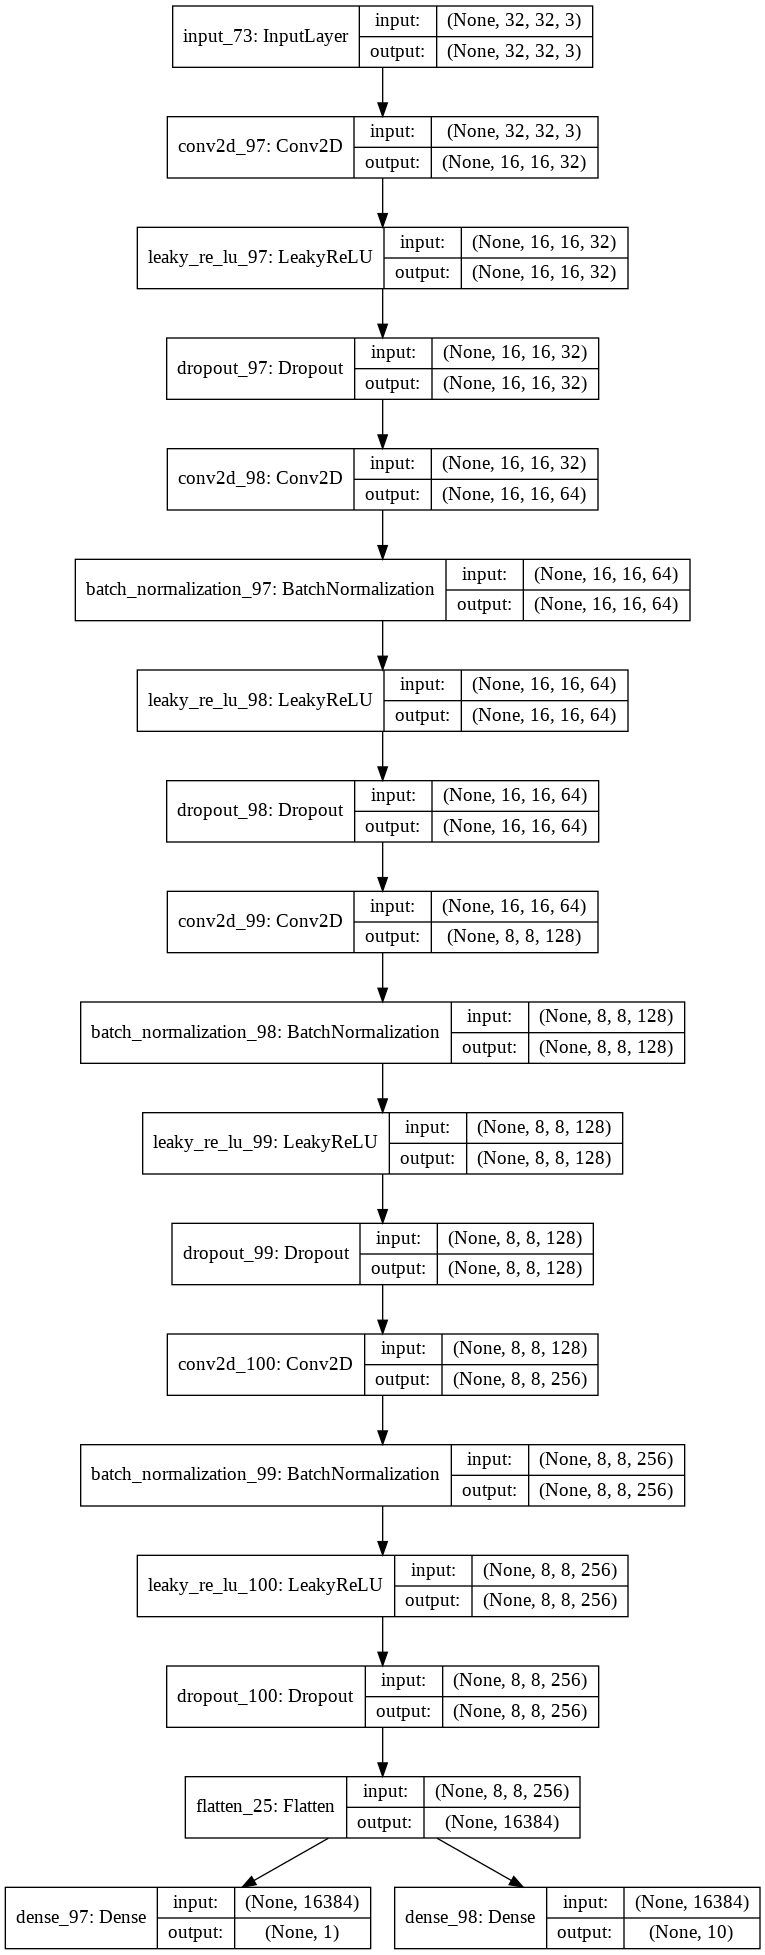

In [71]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 8x8
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## <font color='orange'>Defining a function to define generator model:</font>

The generator model must take a random point from the latent space as input, and the class label, then output a generated image with the shape 32x32x3.

Approach that has proven effective and is now generally recommended is to interpret the class label as an additional channel or feature map early in the generator model.

Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 24576)        2482176     input_75[0][0]                   
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 50)        500         input_74[0][0]                   
___________________________________________________________________________________________

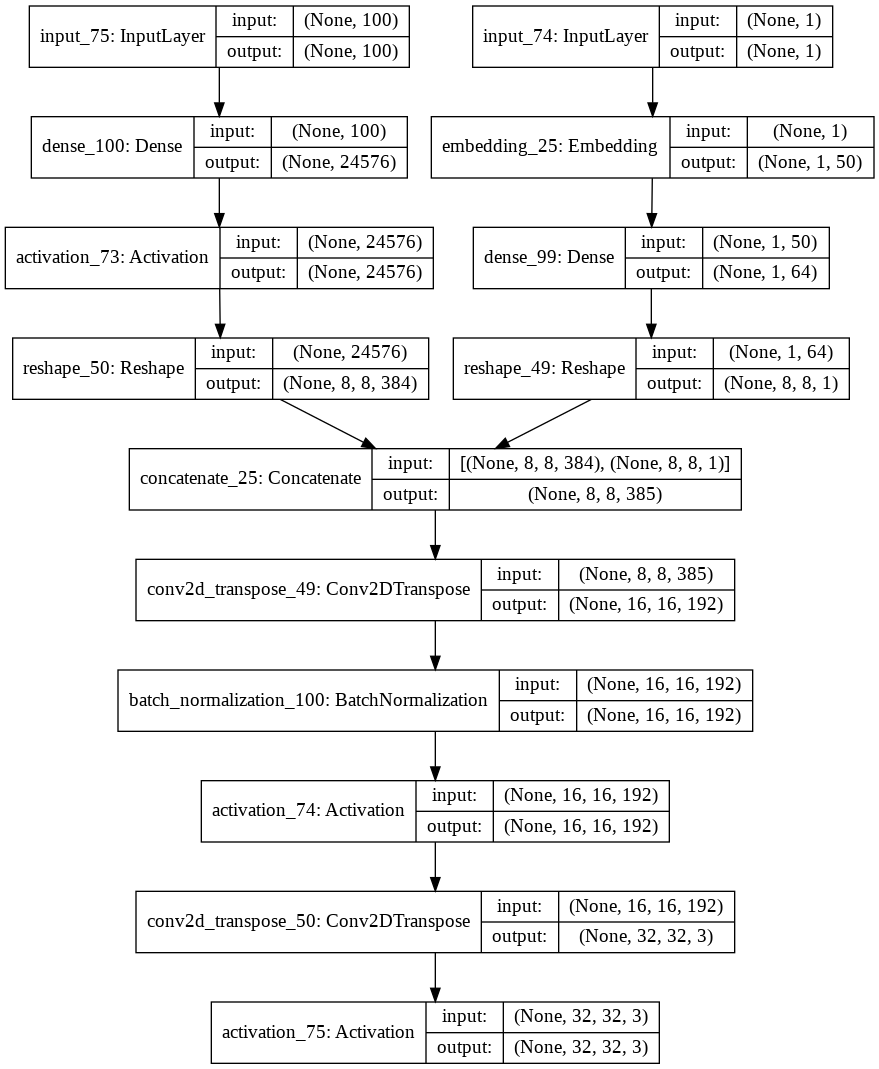

In [72]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 8x8 image
	n_nodes = 384 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 16x16
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## <font color='orange'> AC-GAN Composite Model:</font>

The generator model is not updated directly; instead, it is updated using the discriminator model.

This can be achieved by creating a composite model that stacks the generator model on top of the discriminator model.

Here we implement the function:

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_78 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_77 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_104 (Dense)               (None, 24576)        2482176     input_78[0][0]                   
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1, 50)        500         input_77[0][0]                   
___________________________________________________________________________________________

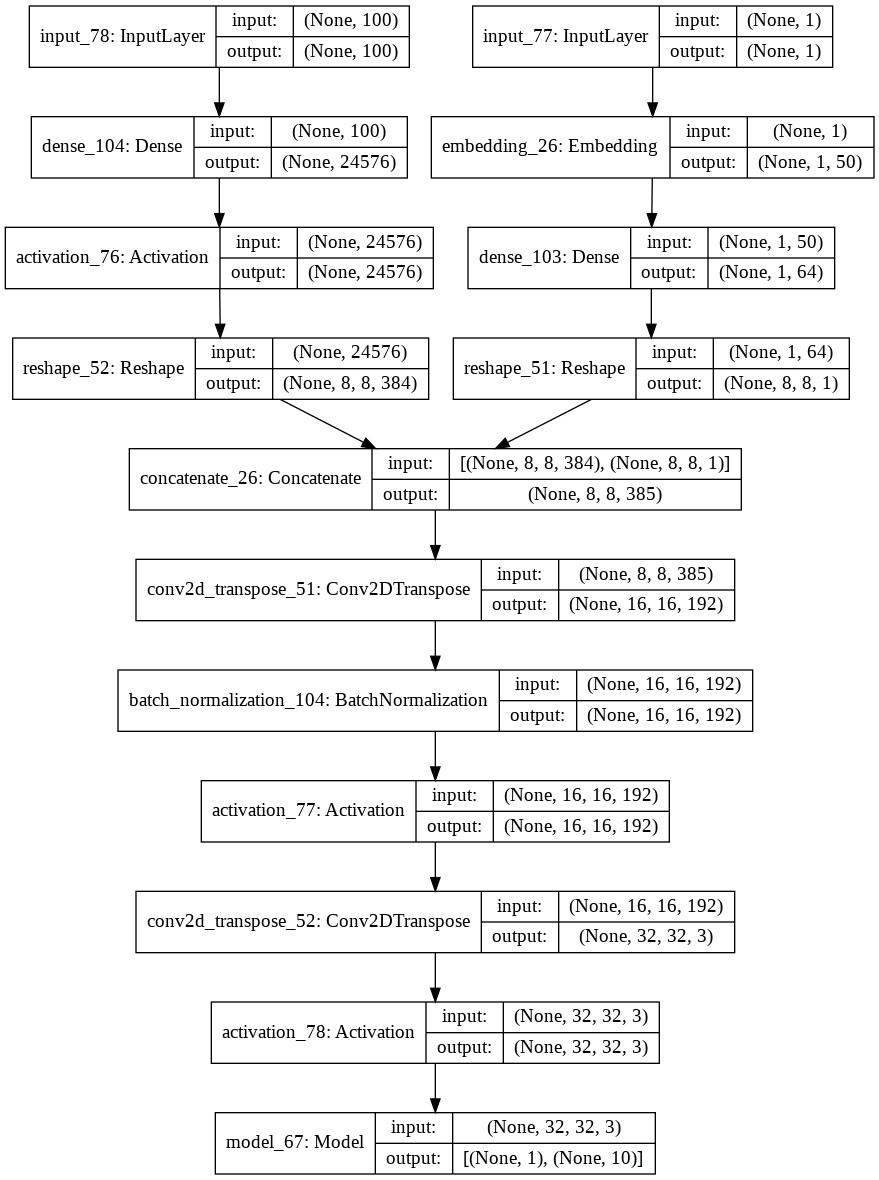

In [73]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # convert from ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    fig = plt.figure(figsize=(10, 10))
    for i in range(100):
        # define subplot
        plt.subplot(10, 10, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[i, :, :, :])
    plt.show()
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)

## <font color='orange'>Defining a function to train discriminator and generator:</font>


In [75]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    dis_loss1 = np.zeros(n_steps)
    gen_loss1 = np.zeros(n_steps)
    dis_loss2 = np.zeros(n_steps)
    gen_loss2 = np.zeros(n_steps)

    for j in range(n_epochs):
        for i in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
            # generate 'fake' examples
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            # sum of d loss
            d_loss1_tot = d_r1 + d_f
            d_loss2_tot = d_r2 + d_f2
            dis_loss1[j*bat_per_epo + i] = d_loss1_tot
            dis_loss2[j*bat_per_epo + i] = d_loss2_tot
            # prepare points in latent space as input for the generator
            [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            gen_loss1[j*bat_per_epo + i] = g_1
            gen_loss2[j*bat_per_epo + i] = g_2
        # summarize loss on this batch
        print('epoch %d finished, dr: (%.3f,%.3f), df: (%.3f,%.3f), g: (%.3f,%.3f)' % (j+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if j % 20 == 0:
            summarize_performance(j, g_model, latent_dim)
    return dis_loss1, dis_loss2, gen_loss1, gen_loss2

## <font color='orange'>Start training:</font>

Here we use the above function to train our model (discriminator and generator).

(50000, 32, 32, 3) (50000, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


epoch 1 finished, dr: (0.040,2.448), df: (0.005,0.186), g: (8.220,0.102)


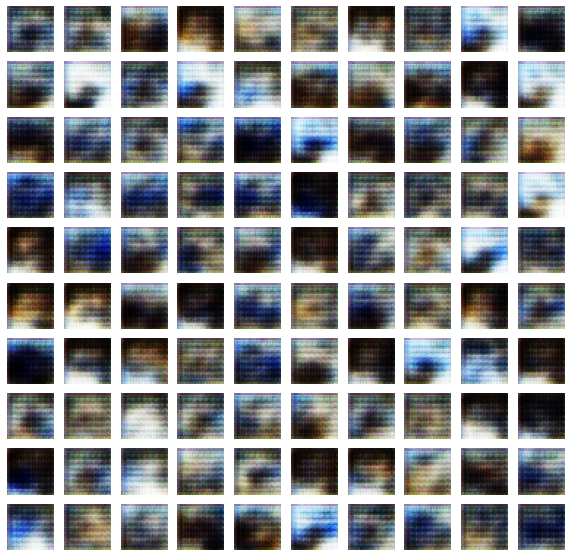

epoch 2 finished, dr: (0.061,1.925), df: (0.011,0.195), g: (7.351,0.085)
epoch 3 finished, dr: (2.068,2.031), df: (1.444,0.149), g: (1.608,0.104)
epoch 4 finished, dr: (0.372,1.485), df: (0.251,0.182), g: (1.350,0.159)
epoch 5 finished, dr: (0.016,1.267), df: (0.213,0.208), g: (1.973,0.191)
epoch 6 finished, dr: (0.043,1.829), df: (0.370,0.136), g: (4.809,0.082)
epoch 7 finished, dr: (0.097,1.397), df: (0.112,0.239), g: (1.711,0.212)
epoch 8 finished, dr: (0.115,1.787), df: (0.003,0.214), g: (2.576,0.198)
epoch 9 finished, dr: (0.186,1.069), df: (0.571,0.101), g: (0.975,0.346)
epoch 10 finished, dr: (0.098,1.716), df: (0.448,0.214), g: (2.485,0.222)
epoch 11 finished, dr: (0.072,1.890), df: (0.566,0.329), g: (1.637,0.278)
epoch 12 finished, dr: (1.142,1.742), df: (0.048,0.200), g: (2.960,0.513)
epoch 13 finished, dr: (0.285,1.618), df: (0.031,0.182), g: (2.434,0.170)
epoch 14 finished, dr: (0.371,1.373), df: (0.115,0.190), g: (2.972,0.039)
epoch 15 finished, dr: (0.992,1.362), df: (0.1

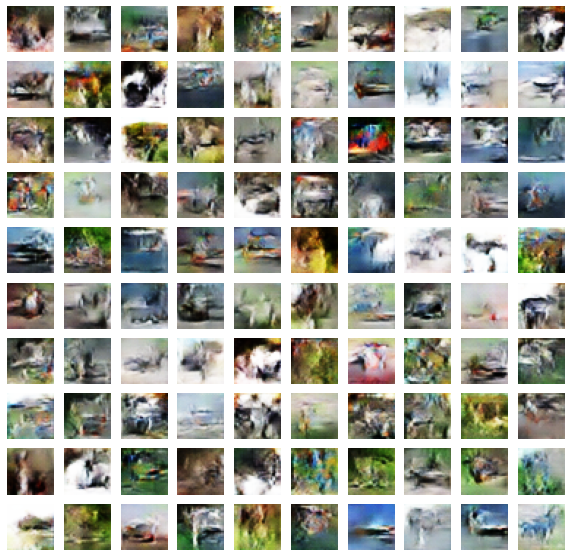

epoch 22 finished, dr: (0.408,0.972), df: (0.589,0.145), g: (1.545,0.213)
epoch 23 finished, dr: (0.307,1.195), df: (0.582,0.168), g: (1.251,0.132)
epoch 24 finished, dr: (0.695,1.741), df: (0.715,0.232), g: (1.184,0.077)
epoch 25 finished, dr: (0.452,1.704), df: (0.758,0.248), g: (1.658,0.136)
epoch 26 finished, dr: (0.593,1.028), df: (0.672,0.123), g: (2.104,0.335)
epoch 27 finished, dr: (1.145,1.130), df: (1.051,0.157), g: (1.231,0.181)
epoch 28 finished, dr: (0.762,1.229), df: (0.576,0.122), g: (1.741,0.107)
epoch 29 finished, dr: (0.529,1.021), df: (0.321,0.086), g: (1.733,0.118)
epoch 30 finished, dr: (0.308,1.905), df: (0.561,0.164), g: (1.309,0.272)
epoch 31 finished, dr: (0.392,1.032), df: (0.337,0.148), g: (1.997,0.148)
epoch 32 finished, dr: (0.652,1.318), df: (0.453,0.070), g: (1.383,0.132)
epoch 33 finished, dr: (0.569,1.043), df: (0.427,0.090), g: (1.931,0.107)
epoch 34 finished, dr: (0.782,1.636), df: (0.459,0.146), g: (1.540,0.130)
epoch 35 finished, dr: (0.229,1.317), 

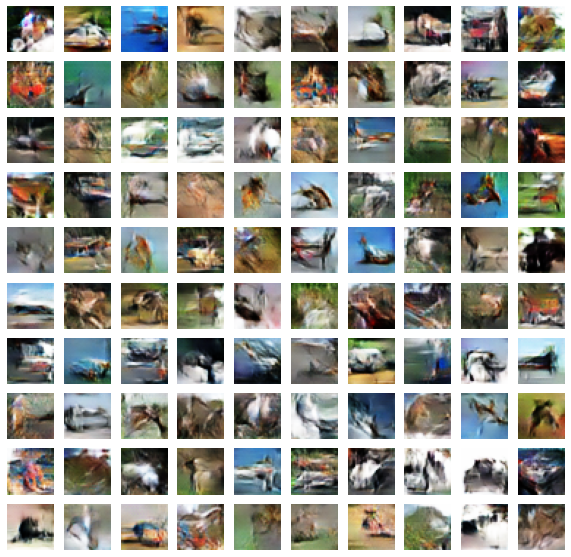

epoch 42 finished, dr: (0.531,1.116), df: (0.533,0.042), g: (1.221,0.140)
epoch 43 finished, dr: (0.601,1.159), df: (0.553,0.145), g: (1.134,0.065)
epoch 44 finished, dr: (0.443,1.107), df: (0.545,0.109), g: (1.388,0.070)
epoch 45 finished, dr: (0.539,1.190), df: (0.518,0.115), g: (1.006,0.176)
epoch 46 finished, dr: (0.472,1.317), df: (0.520,0.048), g: (0.976,0.105)
epoch 47 finished, dr: (0.551,1.166), df: (0.708,0.118), g: (1.223,0.064)
epoch 48 finished, dr: (0.916,1.737), df: (0.780,0.144), g: (1.327,0.071)
epoch 49 finished, dr: (0.612,1.179), df: (0.500,0.115), g: (1.006,0.103)
epoch 50 finished, dr: (0.699,0.904), df: (0.639,0.056), g: (1.192,0.053)
epoch 51 finished, dr: (0.397,0.945), df: (0.549,0.040), g: (1.124,0.103)
epoch 52 finished, dr: (0.497,1.065), df: (0.572,0.150), g: (1.236,0.090)
epoch 53 finished, dr: (0.608,0.799), df: (0.740,0.367), g: (1.093,0.072)
epoch 54 finished, dr: (0.656,1.104), df: (0.566,0.078), g: (1.084,0.092)
epoch 55 finished, dr: (0.856,1.318), 

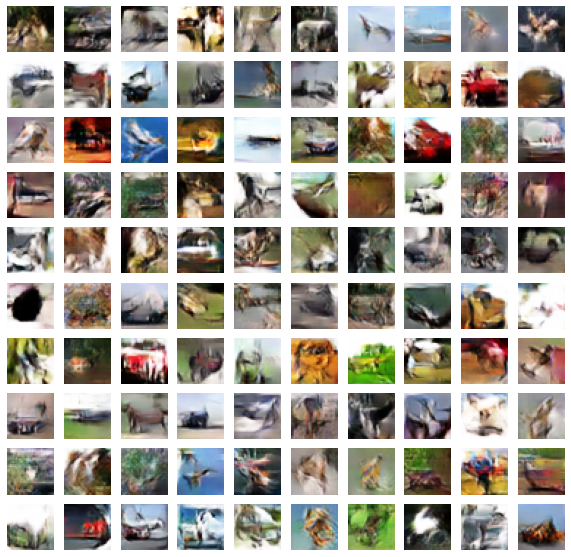

epoch 62 finished, dr: (0.981,1.063), df: (0.641,0.063), g: (0.947,0.126)
epoch 63 finished, dr: (0.444,1.183), df: (0.612,0.063), g: (1.192,0.117)
epoch 64 finished, dr: (0.623,1.180), df: (0.807,0.136), g: (0.917,0.130)
epoch 65 finished, dr: (0.647,1.329), df: (0.611,0.104), g: (1.080,0.109)
epoch 66 finished, dr: (0.799,1.603), df: (0.343,0.031), g: (0.988,0.083)
epoch 67 finished, dr: (0.629,0.928), df: (0.371,0.097), g: (1.317,0.126)
epoch 68 finished, dr: (0.812,1.180), df: (0.804,0.072), g: (0.984,0.251)
epoch 69 finished, dr: (0.476,1.224), df: (0.638,0.056), g: (1.010,0.069)
epoch 70 finished, dr: (0.867,0.965), df: (0.685,0.088), g: (1.288,0.116)
epoch 71 finished, dr: (0.664,0.863), df: (0.769,0.143), g: (0.937,0.091)
epoch 72 finished, dr: (0.601,1.265), df: (0.673,0.137), g: (1.061,0.087)
epoch 73 finished, dr: (0.532,0.990), df: (0.613,0.351), g: (0.947,0.131)
epoch 74 finished, dr: (0.774,0.884), df: (0.515,0.096), g: (1.362,0.104)
epoch 75 finished, dr: (0.668,0.795), 

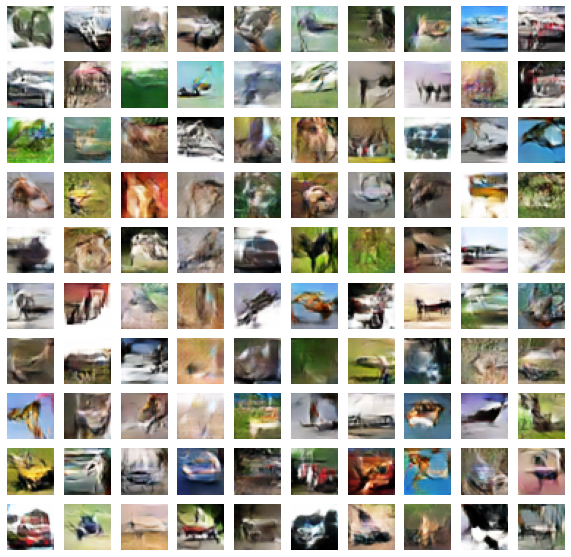

epoch 82 finished, dr: (0.927,1.253), df: (0.560,0.099), g: (0.846,0.114)
epoch 83 finished, dr: (0.610,1.102), df: (0.764,0.072), g: (1.065,0.066)
epoch 84 finished, dr: (0.749,0.647), df: (0.662,0.095), g: (1.072,0.083)
epoch 85 finished, dr: (0.475,1.129), df: (0.560,0.074), g: (1.283,0.088)
epoch 86 finished, dr: (0.668,1.382), df: (0.911,0.161), g: (1.097,0.069)
epoch 87 finished, dr: (0.552,0.676), df: (0.541,0.155), g: (1.138,0.133)
epoch 88 finished, dr: (0.522,1.671), df: (0.634,0.091), g: (1.369,0.099)
epoch 89 finished, dr: (0.600,0.831), df: (0.640,0.085), g: (0.999,0.105)
epoch 90 finished, dr: (0.869,1.061), df: (0.674,0.088), g: (1.060,0.157)
epoch 91 finished, dr: (0.779,0.992), df: (0.802,0.093), g: (1.084,0.130)
epoch 92 finished, dr: (0.608,1.027), df: (0.796,0.111), g: (0.974,0.167)
epoch 93 finished, dr: (0.681,0.973), df: (0.475,0.151), g: (1.118,0.118)
epoch 94 finished, dr: (0.813,0.959), df: (0.586,0.101), g: (1.128,0.062)
epoch 95 finished, dr: (0.457,1.003), 

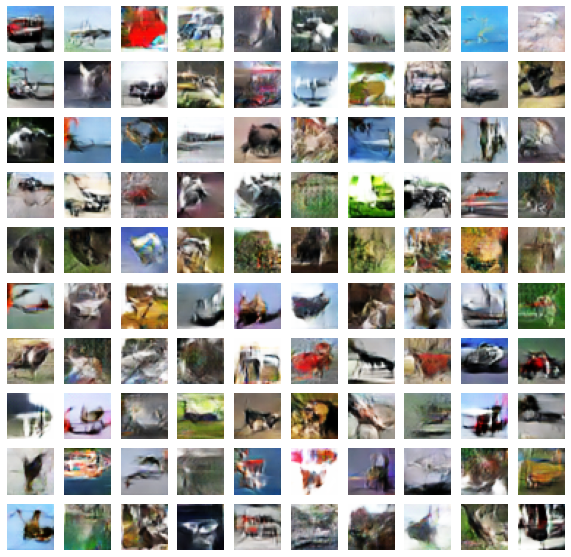

In [76]:
n_epochs = 101
n_batch = 64
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
dis_loss1, dis_loss2, gen_loss1, gen_loss2 = train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs, n_batch)

Text(0.5, 1.0, "AC-GAN Model discriminator and generator's Loss FOR output 1")

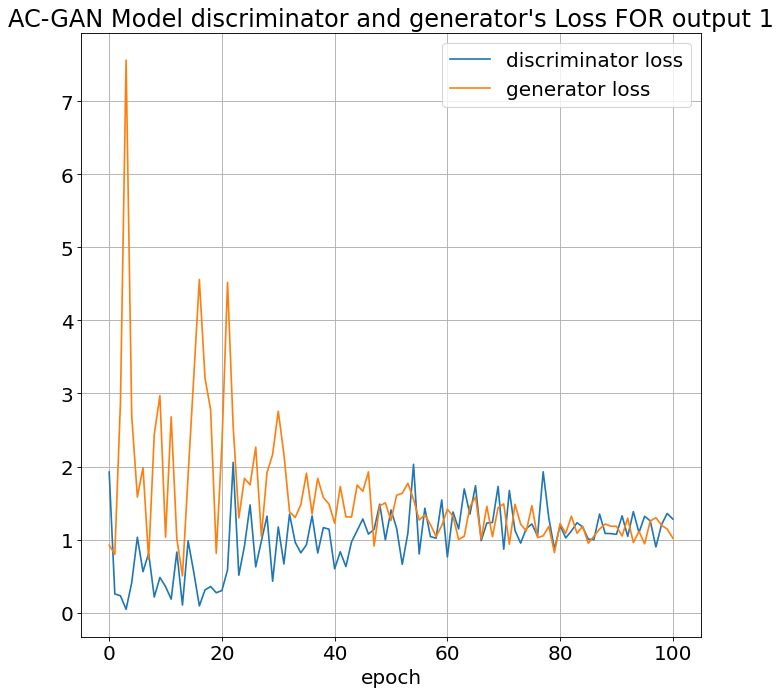

In [77]:
batch_per_epoch = int(50000/n_epochs)
plot_range = np.arange(n_epochs) * batch_per_epoch
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

plt.plot(dis_loss1[plot_range], label="discriminator loss")
plt.plot(gen_loss1[plot_range], label="generator loss")
plt.grid('on')
plt.legend()
plt.xlabel("epoch")
plt.title('AC-GAN Model discriminator and generator\'s Loss FOR output 1')

Text(0.5, 1.0, "AC-GAN Model discriminator and generator's Loss FOR output 2")

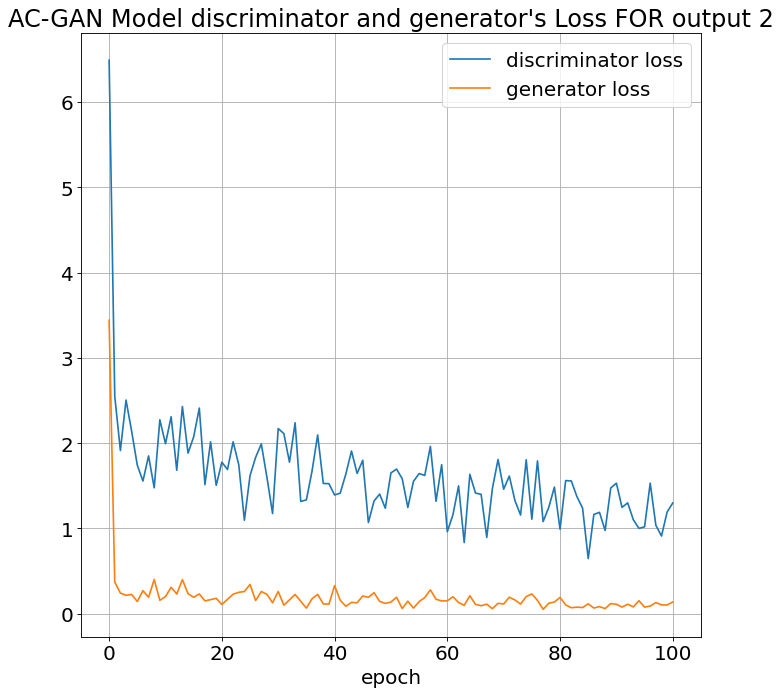

In [79]:
batch_per_epoch = int(50000/n_epochs)
plot_range = np.arange(n_epochs) * batch_per_epoch
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

plt.plot(dis_loss2[plot_range], label="discriminator loss")
plt.plot(gen_loss2[plot_range], label="generator loss")
plt.grid('on')
plt.legend()
plt.xlabel("epoch")
plt.title('AC-GAN Model discriminator and generator\'s Loss FOR output 2')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


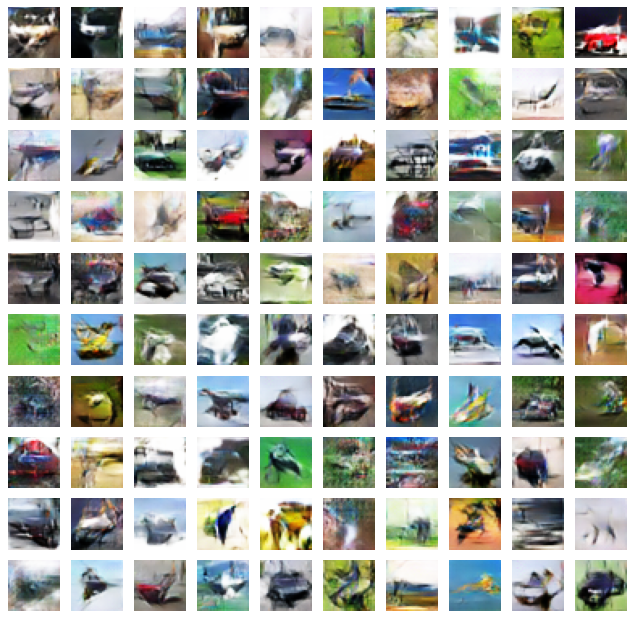

In [105]:
# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    plt.figure(num=None, figsize=(10, 10), dpi=80)
    for i in range(n_examples):
        # define subplot
        plt.subplot(np.sqrt(n_examples), np.sqrt(n_examples), 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, :])
    plt.show()

# load model
model = load_model('model_0101.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)

In [78]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [83]:
'model_%04d.h5' % (101)

'model_0101.h5'